## dp-VAE Improvements

#### By Caelin Kaplan

### Executive Summary

This notebook explains improvements made to the VAE implementation based on state-of-the-art data generation methods [1]. It also identifies the best configuration of data transformer, model parameters, and differential privacy options, for the Adult and Diamonds datasets.

### Table of Contents

I. Improvements

* New Development Framework
* Data Transformation
* Loss Function

II. Best Experiment Configuration

* Adult Dataset
* Diamonds Dataset

III. Conclusion

* General Analysis
* Future Work

IV. Appendix

* Use of Batch Normalization

### References

[1] https://papers.nips.cc/paper/8953-modeling-tabular-data-using-conditional-gan.pdf

[2] https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

[3] https://arxiv.org/pdf/1704.00028.pdf

[4] https://openreview.net/pdf?id=rkjZ2Pcxe

[5] https://arxiv.org/pdf/1511.07289.pdf

[6] https://www.tensorflow.org/tutorials/generative/cvae

[7] https://papers.nips.cc/paper/9681-differential-privacy-has-disparate-impact-on-model-accuracy.pdf

## I. Improvements

### New Development Framework

The development framework is designed with the purpose of enabling a systematic approach to training and evaluating differentially private generative models. A comprehensive tutorial can be found in the README. 

GitHub Address: https://github.wdf.sap.corp/I534524/dp-generative-models

### Data Transformation

The standard method of transforming data before passing it to a deep learning model is to apply a min-max scaling for continuous features and one-hot encoding for categorical features. Within the framework, GeneralTransformer is implemented to have this functionality. [1] proposes a novel approach to data transformation that is called Mode-specific Normalization (Section 4.2). The process can be broken down into the following steps:

1.	For each continuous column, use a Bayesian Gaussian Mixture Model to estimate the number of modes and fit a Gaussian Mixture. 
2.	For each value in the column, compute the probability that the value comes from each of the modes. 
3.	Sample one of the modes from the probability density and use the sampled mode to standardize the value (e.g. subtract the value by the mode’s mean and divide by the mode’s standard deviation).

For the $i^{th}$ value of the $j^{th}$ column, if the second mode is selected, then the mode-standardized value is equal to,

$$ v_{i,j} = \frac{v - \eta_{2}}{4\phi_{2}}, $$

where $\eta$ is the mode mean and $\phi$ is the mode standard deviation. The mode's standard deviation is multiplied by four in order to keep the majority of the data within the range of -1 to 1. Applying mode-specific normalization to a column results in a vector containing the mode-standardized value and a  one-hot encoding representing the selected mode number. For example, if the number of modes in the mixture's probability density is five, then the original continuous value is transformed into the following vector:

$$ [v_{i,j}, 0, 1, 0, 0, 0] .$$

Mode-specific normalization is implemented in the framework as BGMTransformer.

### Loss Function

The VAE loss has two parts: a reconstruction error and regularization error. In the standard VAE formulation, the regularization term is the KL Divergence between the latent distribution, z, and a standard gaussian. Furthermore, the reconstruction term represents the difference between the generated data that results from the decoder, d(z), and the actual data, x. The diagram below displays the VAE structure and loss [2].

<img src="vae-loss.png">

The above diagram presents the reconstruction error as the sum of squared errors between the original and generated features. Indeed, this is the standard approach when the features are continuous. Alternatively, when the features are categorical, the cross entropy loss is usually applied. 

In the case of tabular data generation, where the features can be both continuous or categorical, the two most common practices are to have a "combined" loss function or train two separate models. The problem with training two separate models is that the VAE is no longer able to generate data that maintains the correlations between continuous and categorical features. Therefore, the method I chose is to implement a loss function that calculates the sum of squared errors for continuous features and the cross entropy for categorical features. For a given feature, the loss function is:

\begin{equation}
Loss = 
\begin{cases}
continuous: \frac{1}{2} \lVert x-\hat{x} \rVert_{2}^{2} \\
categorical: -\sum_{i=1}^{n}\sum_{c=1}^{M}y_{i}log(p_{i, c}),
\end{cases}
\end{equation}

where x and $\hat{x}$ are real valued feature vectors, n is the number of observations in a categorical feature, M is the number of categories, $y_{i}$ is an indicator value for whether the class, c, is the true class, and $p_{i,c}$ is the predicted probability that observation o is in class c.

## II. Best Experiment Configuration

In this section, we display the best model configurations both with and without differential privacy. Evaluating the quality of generated data without differential privacy is important because it provides a ceiling on the expectations that one should have when generating data from a given model. 

The quality of generated data is evaluated with the following strategy:

1. Train a model using real train data.
2. Train a model using fake data.
3. Predict a test set of real data using both models.
4. Compare the quality of the predictions.

Note about evaluation: For the Adult dataset the F1-score is calculated with respect to the minority class; this is the same evaluation strategy used in [1].

In [2]:
from model_experiments.vae_experiment import VaeExperiment
from general.experiment import GenerativeModelType, TransformerType, OptimizerType
from general.utils import OutputActivation
from evaluators.machine_learning_evaluator import MachineLearningEvaluator, EvaluatorModelType, MetricType, ScalerType

import json
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
from IPython.display import HTML

In [19]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### 1. Adult Dataset

### A. Without Differential Privacy

### Model Configuration

In [2]:
# config = '3a3bddf547bc35ba97da6ed4a08a6a33a1cdde13.pkl'  # vae_experiment3 - better distribution plots
config = "627fecb25f4c789acc1c62eb3ffccd1030ff6346.pkl"  # vae_experiment2 - same configuration as [1]
eval_input = {'target_col': 'output', 'data_path': 'data/', 'config_file': config}
evaluator = MachineLearningEvaluator(**eval_input)
experiment_data = evaluator.get_experiment_data()
experiment_data["config"]

'{"batch_size": 64, "data_path": "data/", "dataset": "adult.csv", "diff_priv": {"l2_norm_clip": 0.2, "microbatches": 1, "noise_multiplier": 1.0}, "dp_optimizer_type": 1, "early_stop": {"early_stop_first_epoch": 4, "early_stop_loss_pct": 0.8, "early_stop_n_previous_losses": 10, "with_early_stop": true}, "epochs": 50, "k_fold": true, "learning_rate": 0.001, "model_config": {"compress_activations": ["relu", "relu"], "compress_dims": [128, 128], "decompress_activations": ["relu", "relu"], "decompress_dims": [128, 128], "latent_dim": 128}, "model_type": 0, "name": "vae_experiment2", "optimizer_type": 5, "output_activations": {"categorical": 3, "continuous": 1}, "test_pct": 0.3, "transformer": {"kwargs": {"cont_range_clipping": true, "n_clusters": 10, "outlier_clipping": false}, "type": 1}, "with_dp": false, "zero_value_threshold": 1.0}'

### Data Utility Test

In [3]:
scores = evaluator.data_utility_scores(
    EvaluatorModelType.LogisticRegression, [MetricType.F1], ScalerType.ROBUST, 
    model_kwargs={"solver": "lbfgs", "class_weight": "balanced", "max_iter": 100})  
display(scores)

Predicting Validation Scores


,test_fake_f1_score,test_real_f1_score,train_fake_f1_score,train_real_f1_score
0,0.621426,0.667074,0.527365,0.673299
1,0.624094,0.671398,0.506294,0.673472
2,0.627536,0.676525,0.477103,0.675534


### Distributions of Generated vs. Real Data

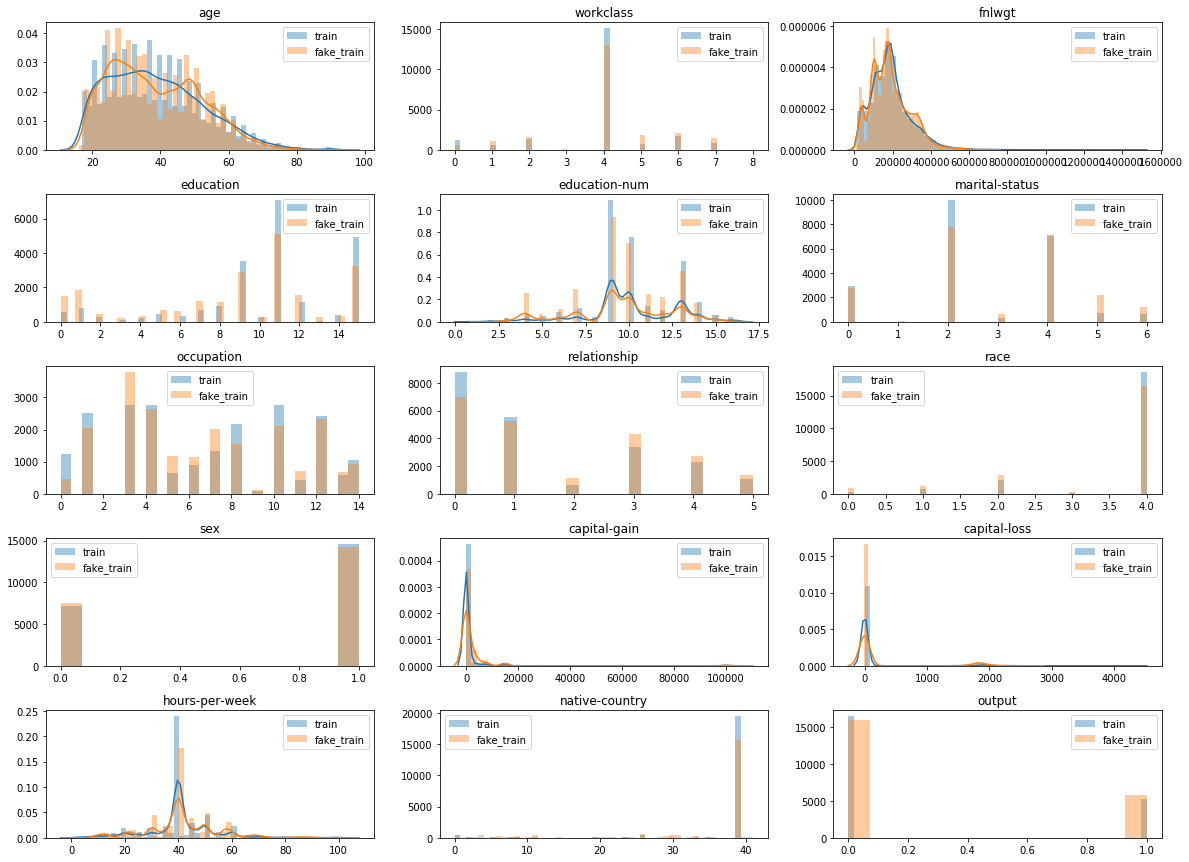

In [291]:
evaluator.plot_distributions(model_run=0, include_test=False)

### Analysis

* The configuration presented here is the same as in [1]. We acheive equivalent data utility using the same prediction model. This is an important result because it verifies that our Tensorflow implementation within the evaluation framework is identical to the released code in PyTorch.


* Using different experiment configurations may boost the data utility slightly; the F1 score improvement is too small to ber certain. It would be necessary to run more experiments before drawing a certain conclusion. 

### B. With Differential Privacy

### Model Configuration

In [4]:
config = 'f81bbaf838fdb998eb76f14e770cb1b1e7714738.pkl'  # vae_experiment
eval_input = {'target_col': 'output', 'data_path': 'data/', 'config_file': config}
evaluator = MachineLearningEvaluator(**eval_input)
experiment_data = evaluator.get_experiment_data()
experiment_data["config"]

'{"batch_size": 64, "data_path": "data/", "dataset": "adult.csv", "diff_priv": {"l2_norm_clip": 5.0, "microbatches": 1, "noise_multiplier": 0.8}, "dp_optimizer_type": 1, "early_stop": {"early_stop_first_epoch": 4, "early_stop_loss_pct": 0.8, "early_stop_n_previous_losses": 15, "with_early_stop": true}, "epochs": 200, "k_fold": true, "learning_rate": 0.001, "model_config": {"compress_activations": ["elu", "elu"], "compress_dims": [128, 128], "decompress_activations": ["elu", "elu"], "decompress_dims": [128, 128], "latent_dim": 128}, "model_type": 0, "name": "vae_experiment4", "optimizer_type": 5, "output_activations": {"categorical": 3, "continuous": 1}, "test_pct": 0.3, "transformer": {"kwargs": {"clip_outliers_first": false, "cont_range_clipping": false, "n_clusters": 6, "outlier_clipping": true}, "type": 1}, "with_dp": true, "zero_value_threshold": 1.0}'

### Data Utility Test

In [5]:
k = len(experiment_data["model_runs"])
for i in range(k):
    print("𝜖 fold {}: {}".format(i+1, np.round(experiment_data["model_runs"][i]["epsilons"][-1], 3)))

𝜖 fold 1: 2.081
𝜖 fold 2: 2.081
𝜖 fold 3: 2.311


In [6]:
scores = evaluator.data_utility_scores(
    EvaluatorModelType.LogisticRegression, [MetricType.F1], ScalerType.ROBUST, 
    model_kwargs={"solver": "lbfgs", "class_weight": "balanced", "max_iter": 100})  
display(scores)

Predicting Validation Scores


,test_fake_f1_score,test_real_f1_score,train_fake_f1_score,train_real_f1_score
0,0.485676,0.683664,0.599511,0.668554
1,0.443839,0.668661,0.674600,0.675176
2,0.465041,0.665042,0.720796,0.674891


### Distributions of Generated vs. Real Data

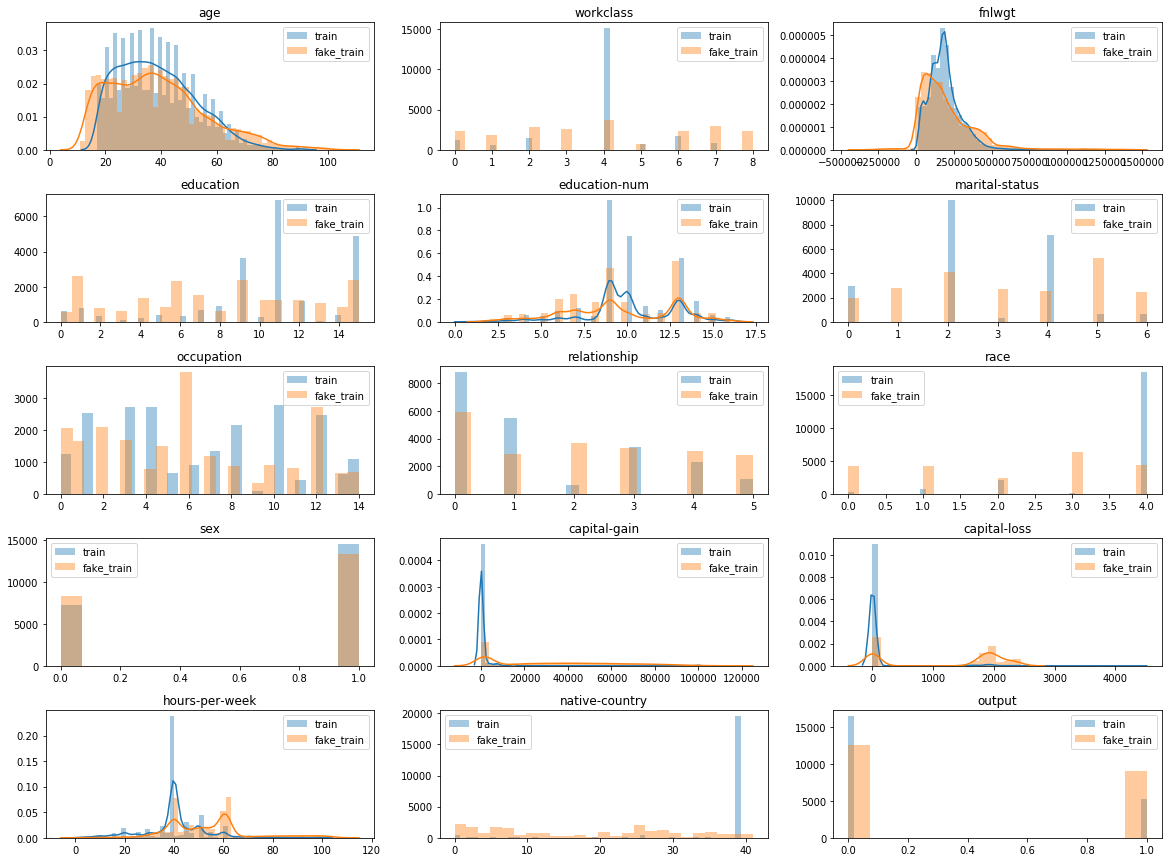

In [295]:
evaluator.plot_distributions(model_run=1, include_test=False)

### Analysis

* As the goal of differential privacy is to protect the anonymity of each record in the data, when a feature contains outliers, it makes sense that dp-SGD will have a more significant impact on the generated feature distributions. This can be seen in the distributions of the categorical features workclass, race, and native-country, where there is a single class that is dominant in the real train data yet the fake data appears to be uniformly distributed. It also is present in continuous features, such as capital-gain, capital-loss, and hours-per-week, because the majority of values are 0, 0, and 40, respectively.


* Generally, each of the best performing configurations with $\epsilon$ equal to ~1.5 result in two folds with an F1 score between .45 and .55 and one with a score of .25-35. By increasing the l2_norm_clip to 5.0, the resulting $\epsilon$ is ~2, but there is more consistent data utility performance. It would be interesting to see how the generated data's vulnerability to membership inference attacks are impacted by this tradeoff.


* The results presented here are for a model that uses dp-Adagrad. Although dp-Adagrad performed better than dp-Adam for this specific configuration, we did not find evidence that this trend holds across other parameter configurations. It is possible that the high l2_norm_clip value (5.0) impacts dp-Adam's effectiveness.  

### 2. Diamonds

### A. Without Differential Privacy

### Model Configuration

In [7]:
config = '1ede442fcff74e5e5dd5763af21a047c5d5601d5.pkl'  # vae_experiment
eval_input = {'target_col': 'price', 'data_path': 'data/', 'config_file': config}
evaluator = MachineLearningEvaluator(**eval_input)
experiment_data = evaluator.get_experiment_data()
experiment_data["config"]

'{"batch_size": 64, "data_path": "data/", "dataset": "diamonds.csv", "diff_priv": {"l2_norm_clip": 0.2, "microbatches": 1, "noise_multiplier": 1.0}, "dp_optimizer_type": 2, "early_stop": {"early_stop_first_epoch": 4, "early_stop_loss_pct": 0.8, "early_stop_n_previous_losses": 10, "with_early_stop": true}, "epochs": 50, "k_fold": true, "learning_rate": 0.001, "model_config": {"compress_activations": ["elu", "elu"], "compress_dims": [64, 64], "decompress_activations": ["elu", "elu"], "decompress_dims": [64, 64], "latent_dim": 64}, "model_type": 0, "name": "vae_experiment", "optimizer_type": 5, "output_activations": {"categorical": 3, "continuous": 1}, "test_pct": 0.3, "transformer": {"kwargs": {"outlier_clipping": true}, "type": 0}, "with_dp": false, "zero_value_threshold": 1.0}'

### Data Utility Test

In [8]:
scores = evaluator.data_utility_scores(
    EvaluatorModelType.LinearRegression, [MetricType.R2_SCORE], ScalerType.ROBUST)
# scores = evaluator.evaluate_machine_learning_efficacy(
#     EvaluatorModelType.RandomForestRegressor, [MetricType.R2_SCORE], ScalerType.ROBUST,
#     model_kwargs={"n_estimators": 300, "max_features": "sqrt", "min_weight_fraction_leaf": .01})
display(scores)

Predicting Validation Scores


,test_fake_r2_score,test_real_r2_score,train_fake_r2_score,train_real_r2_score
0,0.875584,0.919089,0.905407,0.920063
1,0.891310,0.917089,0.928884,0.920387
2,0.879127,0.921261,0.920941,0.918993


### Distributions of Generated vs. Real Data

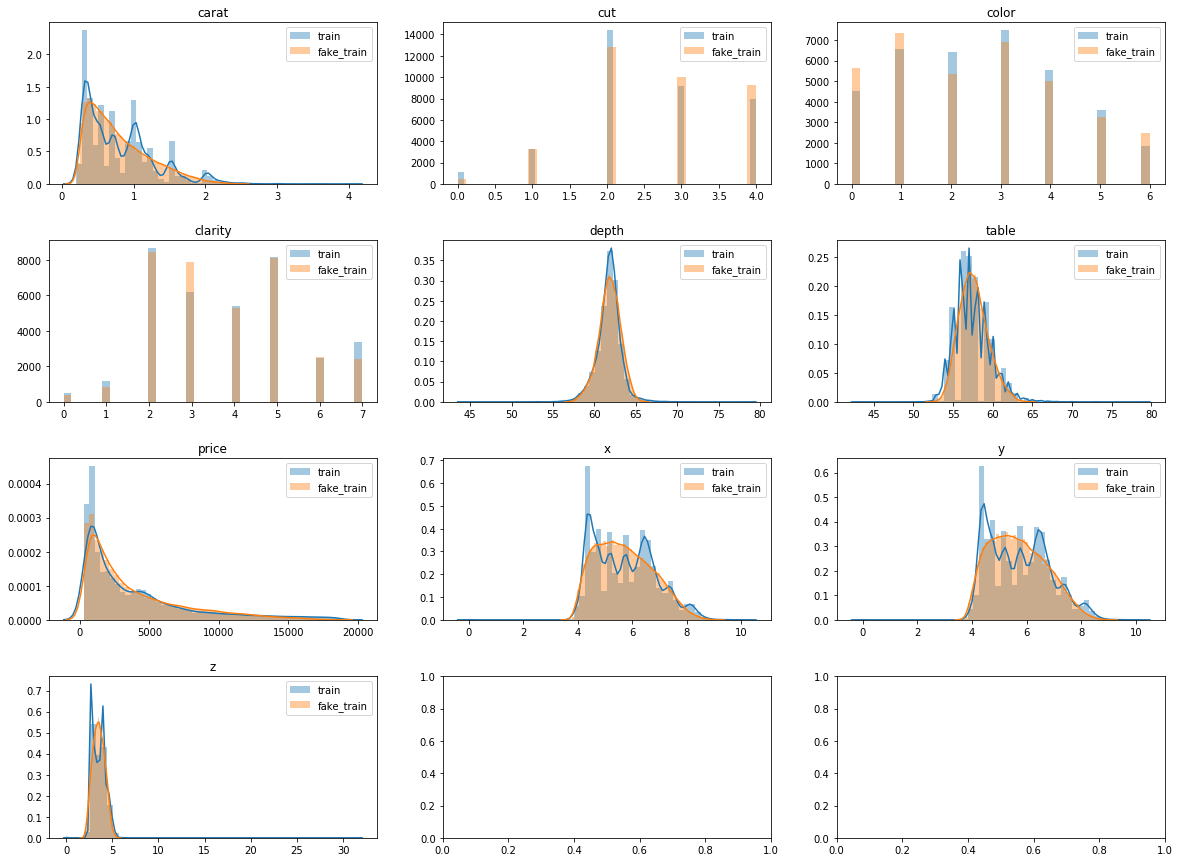

In [298]:
evaluator.plot_distributions(model_run=1, include_test=False)

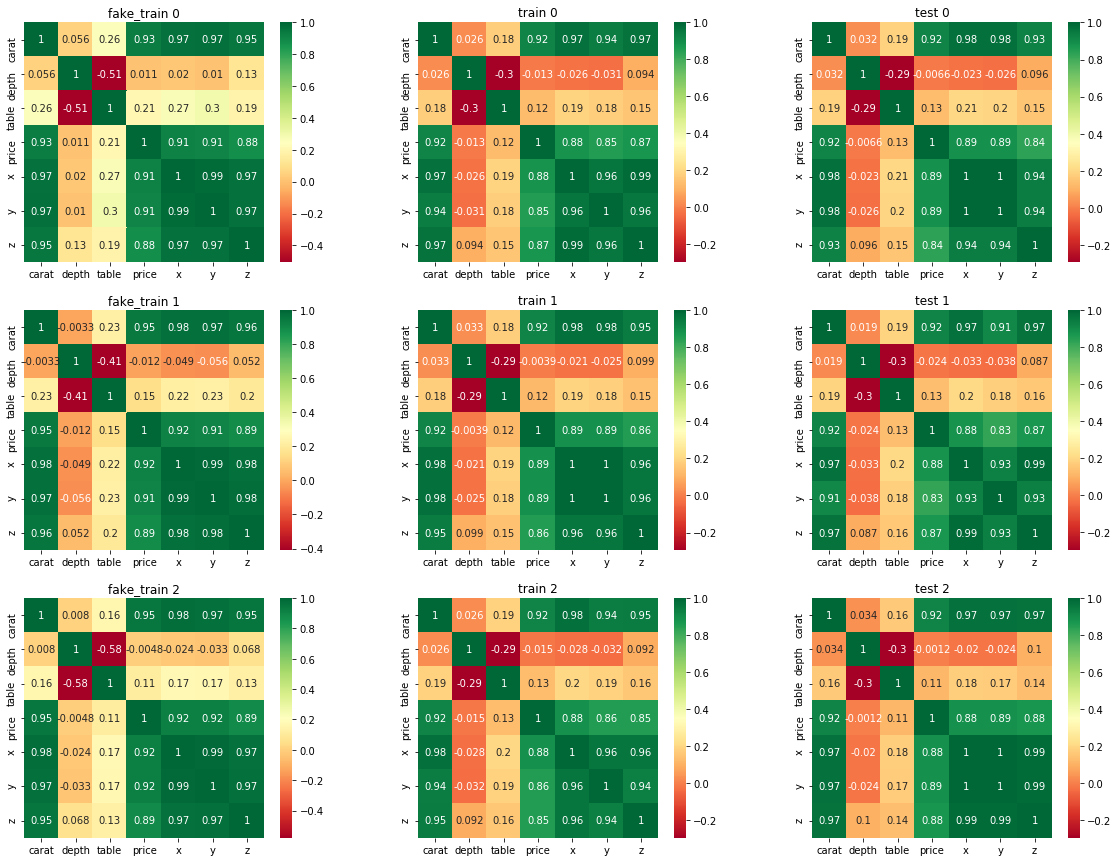

In [299]:
evaluator.plot_heatmap()

### Analysis

* The utility of generated data, without differential privacy, is nearly the same as the real data utility. This implies that the model is fully capable of learning the intricacies of the real data distributions. 


* The model configuration presented above has about 10% more data utility than the others. This is an interesting result, because the best configuration uses the GeneralTransformer, which applies a simpler transformation than the BGMTransformer (described in Section 1.2) to continuous features; it clips outliers greater than four standard deviations away from the mean and then applies min-max scaling between -1 and 1. 

### B. With Differential Privacy

### Model Configuration

In [9]:
# config = "a7b425fb40f3b90d96eb5bc174ae286787d7df2f.pkl" # vae_experiment3
config = "e298802f30f4a2d6573c6ef21d4570b2a5ac81f2.pkl" # vae_experiment3
eval_input = {'target_col': 'price', 'data_path': 'data/', 'config_file': config}
evaluator = MachineLearningEvaluator(**eval_input)
experiment_data = evaluator.get_experiment_data()
experiment_data["config"]

'{"batch_size": 64, "data_path": "data/", "dataset": "diamonds.csv", "diff_priv": {"l2_norm_clip": 0.2, "microbatches": 1, "noise_multiplier": 0.9}, "dp_optimizer_type": 2, "early_stop": {"early_stop_first_epoch": 4, "early_stop_loss_pct": 0.8, "early_stop_n_previous_losses": 10, "with_early_stop": true}, "epochs": 50, "k_fold": true, "learning_rate": 0.001, "model_config": {"compress_activations": ["elu", "elu", "elu"], "compress_dims": [64, 32, 32], "decompress_activations": ["elu", "elu", "elu"], "decompress_dims": [32, 32, 64], "latent_dim": 32}, "model_type": 0, "name": "vae_experiment3", "optimizer_type": 5, "output_activations": {"categorical": 3, "continuous": 2}, "test_pct": 0.3, "transformer": {"kwargs": {"clip_outliers_first": false, "cont_feature_range": [0, 1], "cont_range_clipping": true, "n_clusters": 10, "outlier_clipping": false}, "type": 1}, "with_dp": true, "zero_value_threshold": 1.0}'

### Data Utility Test

In [10]:
k = len(experiment_data["model_runs"])
for i in range(k):
    print("𝜖 fold {}: {}".format(i+1, np.round(experiment_data["model_runs"][i]["epsilons"][-1], 3)))

𝜖 fold 1: 1.64
𝜖 fold 2: 1.71
𝜖 fold 3: 1.733


In [11]:
scores = evaluator.data_utility_scores(
    EvaluatorModelType.LinearRegression, [MetricType.R2_SCORE], ScalerType.ROBUST)
display(scores)

Predicting Validation Scores


,test_fake_r2_score,test_real_r2_score,train_fake_r2_score,train_real_r2_score
0,0.680139,0.917510,0.299758,0.920200
1,0.671634,0.917951,0.527915,0.920610
2,0.646469,0.921958,0.404311,0.918654


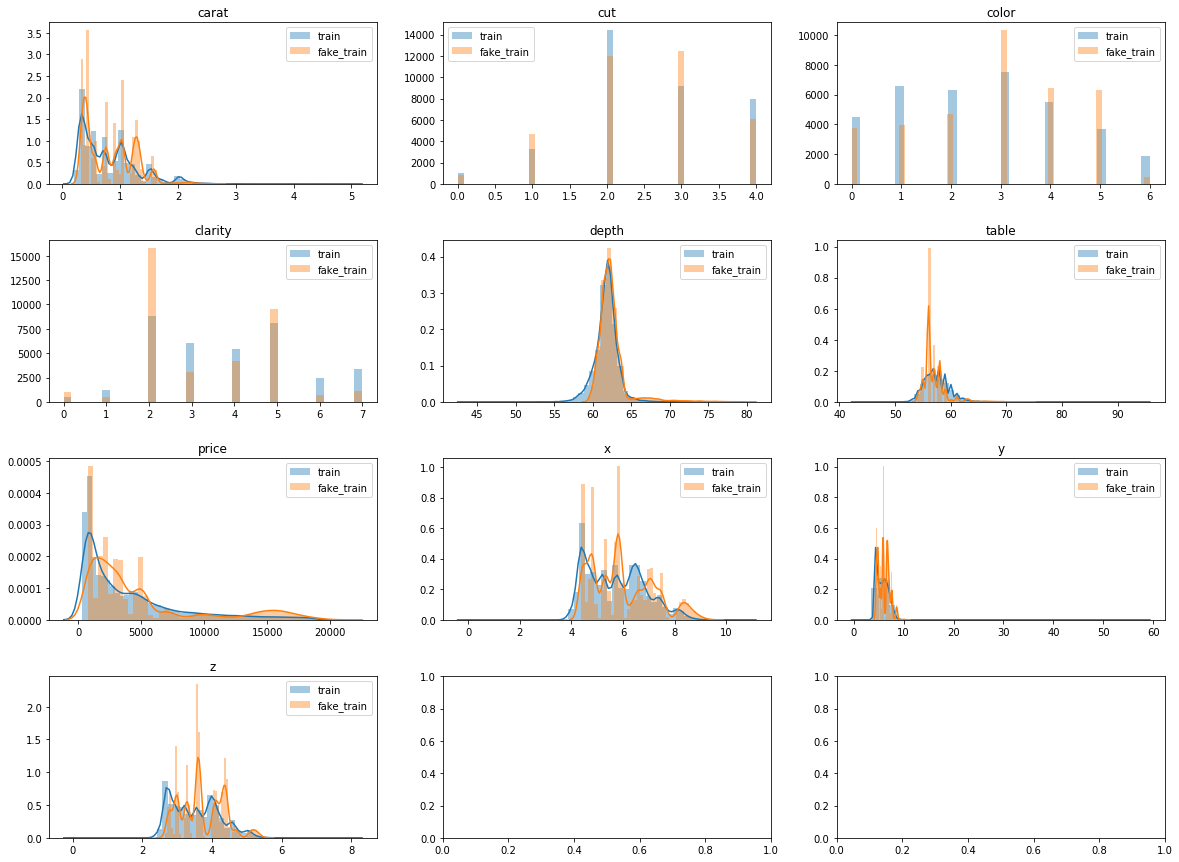

In [303]:
evaluator.plot_distributions(model_run=1, include_test=False)

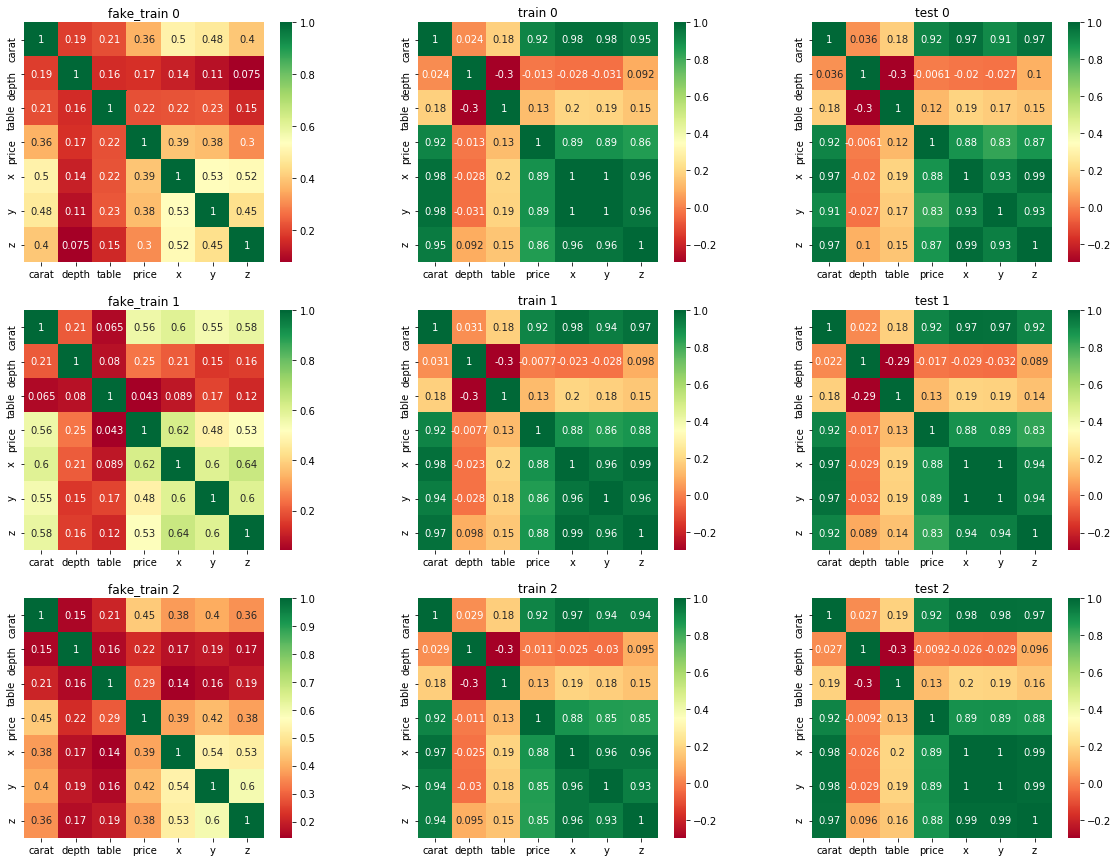

In [304]:
evaluator.plot_heatmap()

### Analysis

* With differential privacy, the best performing model configuration uses encoders/decoders with depth three, a sigmoid output activation for continuous data, and the BGMTransformer (section 1.2) with range clipping between 0 and 1. 


* The impact of the BGMTransformer is clear in the continuous feature distributions. It is parameterized to identify 10 clusters, but the resulting generated data distributions are not smooth. This is because the clusters chosen have a very small standard deviation and the sampling procedure results in values that are tightly grouped around the cluster's mean. Nonetheless, the visual similarity of the histograms is not as important as the generated data's utility, which is about 70% of the real data's utility with an $\epsilon$ ~1.7.


* The heatmaps show that the most correlated features in the real data are still the most correlated features in the fake data. This is big improvement compared to the previous implementation version.

## III. Conclusion

## General Analysis

In [42]:
def extract_scores(config, macro_f1=False):
    eval_input = {'target_col': 'output', 'data_path': 'data/', 'config_file': config}
    evaluator = MachineLearningEvaluator(**eval_input)
    experiment_data = evaluator.get_experiment_data()
    noise_multiplier = json.loads(experiment_data["config"])["diff_priv"]["noise_multiplier"]    
    epsilons = [model_run["epsilons"][-1] for model_run in experiment_data["model_runs"]]    
    if macro_f1:
        metric_kwargs = {MetricType.F1: {"average": "macro"}}
    else:
        metric_kwargs = {}
    scores = evaluator.data_utility_scores(
        EvaluatorModelType.LogisticRegression, [MetricType.F1], ScalerType.ROBUST, 
        model_kwargs={"solver": "lbfgs", "class_weight": "balanced", "max_iter": 100},
        metric_kwargs=metric_kwargs)
    return noise_multiplier, epsilons, scores["test_fake_f1_score"]

### Training Stability

One would expect that if a model is trained with a larger privacy budget, then it will always result in generated data with more utility. During the course of experimenting, we did not find that to be the case. There are two possible explanations.

The first is that the model training procedure with differential privacy is unstable and often fails to converge. This would result in data utility tests that are not always true representations of a model configuration's effectiveness. [3] provides evidence that the use of gradient clipping, which is part of the dp-SGD mechanism, causes the disciminator in GAN training to fail to learn higher order moments of the data and often leads to optimizations problems. It is possible that the same logic applies to other models that utilize gradient clipping. Also, the injection of noise into the gradient during dp-SGD, when significant, may result in additional training instability that cannot always be overcome. 

The second is somewhat counterintuitive. [4] provides evidence that injecting gaussian noise, in controlled amounts, improves the stability of SGD and its variations. As injecting gaussian noise into the gradients is part of the the dp-SGD procedure, it is possible that that for a given dataset and model configuration, sometimes higher levels of noise improve the stability of the training procedure.

Evidence suggests that both interpretations are in-part correct. 

In [4]:
test_config = {
    'dataset': 'adult.csv',
    'name': 'vae_experiment5',
    'diff_priv': {"l2_norm_clip": 5, "enabled": True},
    'model_train': {"seed": 1, 'stratified_by_col': None, "dp_optimizer_type": 2},
    'transformer': {'kwargs': {'n_clusters': 6}, 'type': 1}
}
existing_configs = MachineLearningEvaluator.existing_configs("data/", test_config=test_config)

In [ ]:
test_dict = {"noise_multiplier": [], "eps_mean": [], "eps_std": [], "score_mean": [], "score_std": []}
for config in existing_configs.keys():
    noise_multiplier, epsilons, scores = extract_scores(config)
    test_dict["noise_multiplier"].append(noise_multiplier)
    test_dict["eps_mean"].append(np.mean(epsilons))
    test_dict["eps_std"].append(np.std(epsilons))
    test_dict["score_mean"].append(np.mean(scores))
    test_dict["score_std"].append(np.std(scores))
test_df = pd.DataFrame(test_dict)
test_df["log_eps_mean"] = np.log(test_df["eps_mean"])

Text(0.5, 1.0, 'Adult: F1 Score with Varying Noise Multipliers')

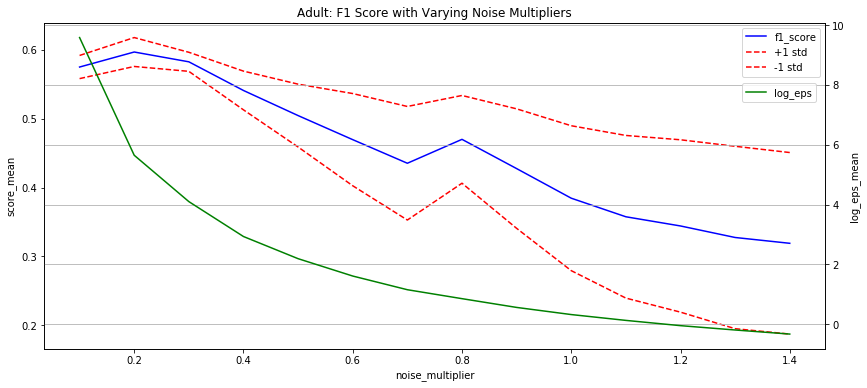

In [15]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot()
plt.plot()
sns.lineplot(data=test_df, x="noise_multiplier", y="score_mean", color="b", label="f1_score", ax=ax)
ax.plot(test_df["noise_multiplier"], test_df["score_mean"]+test_df["score_std"], linestyle="dashed", color="r", label="+1 std")
ax.plot(test_df["noise_multiplier"], test_df["score_mean"]-test_df["score_std"], linestyle="dashed", color="r", label="-1 std")
# ax.legend(loc=0)
ax2 = ax.twinx()
sns.lineplot(data=test_df, x="noise_multiplier", y="log_eps_mean", color="g", ax=ax2, label="log_eps")
plt.grid()
ax.legend(loc="upper right")
ax2.legend(loc="upper right", bbox_to_anchor=(.995, .83))
plt.title("Adult: F1 Score with Varying Noise Multipliers")

I validated these hypotheses by running 10 experiments with the same configuration for the Adult dataset, while varying the noise multiplier for each run. I use the same seed for each experiment in order to control for the randomness that arises from the stochastic operations during pre-processing and training. First, in the above figure, it is visible that epsilon decreases as the noise multiplier increases. This is an expected result. Second, the standard deviation of f1 scores resulting from 3-fold cross validation shrinks as epsilon decreases. The implication is that 3-fold cross validation is suitable to access a model configuration when the resulting epsilon is large, but as the epsilon tends toward 0, it becomes increasing necessary to run the same experiment multiple times. Third, every experiments is run with the same numpy and tensorflow seed, which means that all the random processes in the training procedure are equivalent across runs. Most importantly, the exact noise that is injected into the gradients at each training step is the same; albeit scaled based on the multiplier. 

In the two experiments where the noise multiplier is equal to 0.1 and 0.8, the resulting epsilon is lower and the generated data have more utility than the experiments where the noise multiplier is equal to 0.2 and 0.7, respectively. This is worth investigating further, because the observation implies that it may be possible to find differential privacy parameters that both improve privacy and utility within a range.

To determine whether this finding is legitimate or the result of training instability for a single seed, I conducted the following experiment:

1. Select a model configuration that will remain fixed across all experiments.

2. Select 10 independent seed values.

3. For each seed value, run two experiments: one with noise multiplier equal to 0.8 and another with it equal to 0.7.

4. Calculate the mean f1-score across all 10 experiments for both noise multiplier values.

The two plots below display the distribution of f1 scores and epsilons for the experiments with noise multiplier equal to both 0.8 and 0.7. The results show that the distribution of f1 scores are essentially equivalent for both noise multipliers, yet the resulting epsilon is always less when noise multiplier is equal to 0.8. This suggests that the addition of noise with this specific configuration is not reducing the data utility, while the privacy is increased. Understanding this phenomenon better is a direction for future research.

In [7]:
test_config = {
    'dataset': 'adult.csv',
    'diff_priv': {"l2_norm_clip": 5, "enabled": True},
    'model_train': {'stratified_by_col': None, "dp_optimizer_type": 2},
    'transformer': {'kwargs': {'n_clusters': 6}, 'type': 1}
}

In [8]:
test_config["name"] = 'vae_experiment_noise07'
existing_configs_07 = MachineLearningEvaluator.existing_configs("data/", test_config=test_config)

In [11]:
test_config["name"] = 'vae_experiment_noise08'
existing_configs_08 = MachineLearningEvaluator.existing_configs("data/", test_config=test_config)

In [19]:
test_configs = list(existing_configs_08.keys()) + list(existing_configs_07.keys())

In [ ]:
f1_scores_07, epsilons_07, f1_scores_08, epsilons_08 = [], [], [], []
for config in test_configs:
    noise_multiplier, epsilons, scores = extract_scores(config)
    if noise_multiplier == .7:
        f1_scores_07.extend(scores)
        epsilons_07.extend(epsilons)
    elif noise_multiplier == .8:
        f1_scores_08.extend(scores)
        epsilons_08.extend(epsilons)
    else:
        raise ValueError()

In [21]:
pd.DataFrame({
    "noise_multiplier": [.7, .8], 
    "f1_score_mean": [np.mean(f1_scores_07), np.mean(f1_scores_08)],
    "epsilon_mean": [np.mean(epsilons_07), np.mean(epsilons_08)]
}).round(4)

,noise_multiplier,f1_score_mean,epsilon_mean
0,0.7,0.3311,3.2967
1,0.8,0.3312,2.3432


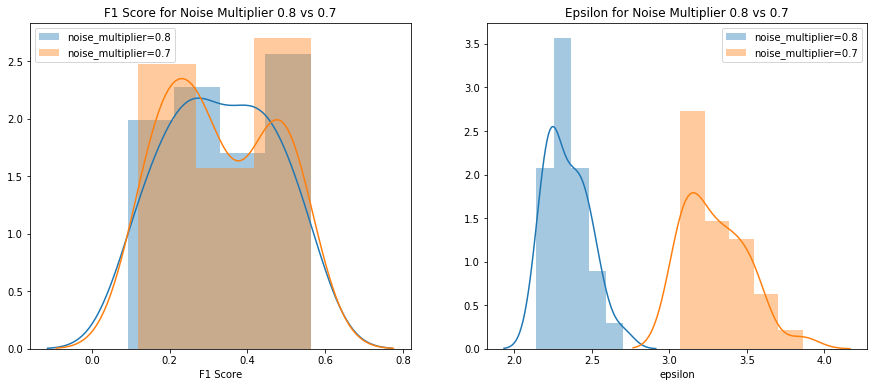

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes[0]
ax.set_title("F1 Score for Noise Multiplier 0.8 vs 0.7")
ax.set_xlabel("F1 Score")
sns.distplot(f1_scores_08, label="noise_multiplier=0.8", ax=ax)
sns.distplot(f1_scores_07, label="noise_multiplier=0.7", ax=ax)
ax.legend()

ax2 = axes[1]
ax2.set_title("Epsilon for Noise Multiplier 0.8 vs 0.7")
ax2.set_xlabel("epsilon")
sns.distplot(epsilons_08, label="noise_multiplier=0.8", ax=ax2)
sns.distplot(epsilons_07, label="noise_multiplier=0.7", ax=ax2)
ax2.legend()

### Impact of Activation Functions

Across the board, when training with differential privacy, the use of ELU (exponential linear unit) as an activation function in the layers of the encoder/decoder performed better than RELU (rectified linear unit). ELU [5] was introduced in order to solve the problem that RELUs make all negative values 0, thus allowing the neuron mean activation to be closer to 0. In practice, it functions similarly to batch normalization. It is worth investigating the use of RELU with batch normalization as an alternative.

## Future Work

* Improve the quality of the generative model. This can involve the use of normalization techniques in the model structure, such as batch normalization (discussed in appendix), layer normalization, or weight normalization. There are also model specific improvements that may be able to be identified. In the case of VAE, one idea is to investigate the use of regularizing the generated data to a non-gaussian distribution.


* Improvement of the use of differential privacy. In this analysis, we use central differential privacy with dp-SGD and its variants, which is implemented in tf-privacy. Investigating the use of other differential privacy approaches, such as local-dp or PATE, is an area worth pursuing. Also, better understanding how the differential privacy parameters, in our case l2_norm_clip and noise_multiplier, can positively or negatively impact model training.

## IV. Appendix

As mentioned previously, it is likely that model training with differential privacy, especially with stringent privacy parameters, is not stable. Although it is not always reccommended to use batch normalization for training a VAE [6], we decided to investigate whether it can help in this case. We compare a model with batch normalization and LeakyReLU activation functions to the model configuration used in the training stability analysis. The two configurations have all the same other parameters, including a noise multiplier of 0.8. We train with the same 10 seeds for a fair comparison.

In terms of the distributions, the difference between the implementations with and without batch normalization can be seen most prominently with the handling of outliers and imbalanced classes. The previous implementation increased the prevelance of outlier values and uncommon classes by generating data that was more uniformly distributed than the real data. With batch normalization, the model takes an alternative approach, which is to remove outliers and uncommon values by generating data that never takes these values. This can be seen in the distributions for workclass, relationship, race, and native country, where the generated data almost always takes the most common class. In some experiment runs, the masking of the minority class for the target feature, output, is also present. Across 10 independent model experiment runs, the most extreme case resulted in 0.4% of the generated data for output taking the minority class, compared to 25% in the real data.  The average run had the minority class account for 11% of the generated feature values for output.

When using batch normalization, despite the minority class for the target feature appearing significantly less often in the generated data than the real data, over the 10 training experiments, the data utility improved. It should be noted that even though the differential privacy parameters are the same for both experiment configurations, $\epsilon$ is generally larger when using batch normalization because the model trains for more epochs before early stop is triggered. Furthermore, the f1-score improvement is completely concentrated in predicting the minority class. [7] has shown that dp-SGD has a disparate negative impact on underrepresented classes. This initial research suggests that possibly the inclusion of batch normalization in the model architecture serves to stabilize dp-SGD such that the minority class information is not lost during training. 

In [13]:
test_config = {
    'dataset': 'adult.csv',
    'diff_priv': {"l2_norm_clip": 5, "enabled": True},
    'model_train': {"dp_optimizer_type": 2},
    'transformer': {'kwargs': {'n_clusters': 6}, 'type': 1},
    "model_config": {"batch_norm": True}
}

In [14]:
existing_configs_bn = MachineLearningEvaluator.existing_configs("data/", test_config=test_config)

In [ ]:
f1_scores_bn, f1_scores_bn_macro, epsilons_bn, = [], [], []
for config in list(existing_configs_bn.keys()):
    noise_multiplier, epsilons, scores = extract_scores(config, macro_f1=False)
    _, _, scores_macro = extract_scores(config, macro_f1=True)
    f1_scores_bn.extend(scores)
    epsilons_bn.extend(epsilons)
    f1_scores_bn_macro.extend(scores_macro)

In [ ]:
f1_scores_08, f1_scores_08_macro, epsilons_08, = [], [], []
for config in list(existing_configs_08.keys()):
    noise_multiplier, epsilons, scores = extract_scores(config, macro_f1=False)
    _, _, scores_macro = extract_scores(config, macro_f1=True)
    f1_scores_08.extend(scores)
    epsilons_08.extend(epsilons)
    f1_scores_08_macro.extend(scores_macro)

In [82]:
f1_scores_bn_minority = np.array(f1_scores_bn)
f1_scores_08_minority = np.array(f1_scores_08)
f1_scores_bn_macro = np.array(f1_scores_bn_macro)
f1_scores_08_macro = np.array(f1_scores_08_macro)
f1_scores_bn_majority = f1_scores_bn_macro * 2 - f1_scores_bn
f1_scores_08_majority = f1_scores_08_macro * 2 - f1_scores_08

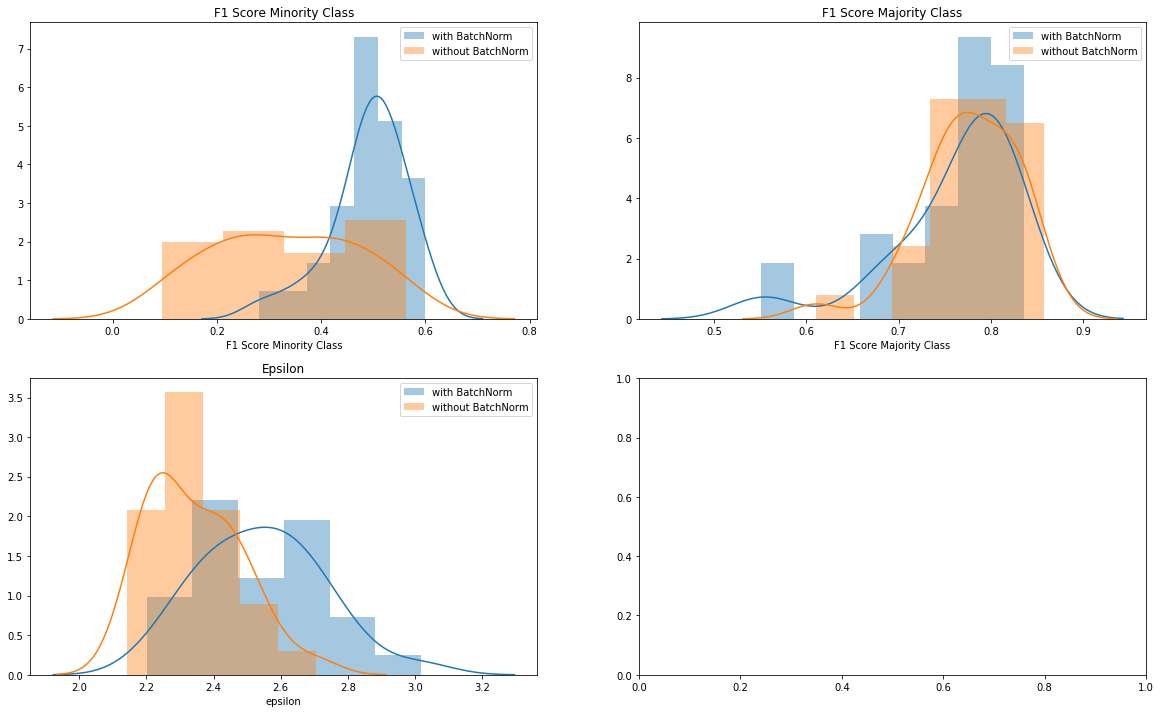

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
ax = axes[0][0]
ax.set_title("F1 Score Minority Class")
ax.set_xlabel("F1 Score Minority Class")
sns.distplot(f1_scores_bn_minority, label="with BatchNorm", ax=ax)
sns.distplot(f1_scores_08_minority, label="without BatchNorm", ax=ax)
ax.legend()

ax2 = axes[0][1]
ax2.set_title("F1 Score Majority Class")
ax2.set_xlabel("F1 Score Majority Class")
sns.distplot(f1_scores_bn_majority, label="with BatchNorm", ax=ax2)
sns.distplot(f1_scores_08_majority, label="without BatchNorm", ax=ax2)
ax2.legend()

ax3 = axes[1][0]
ax3.set_title("Epsilon")
ax3.set_xlabel("epsilon")
sns.distplot(epsilons_bn, label="with BatchNorm", ax=ax3)
sns.distplot(epsilons_08, label="without BatchNorm", ax=ax3)
ax3.legend()

In [73]:
config = 'f968cca34dd8113209682a1a896189c283b88468.pkl'  # vae_experiment
eval_input = {'target_col': 'output', 'data_path': 'data/', 'config_file': config}
evaluator = MachineLearningEvaluator(**eval_input)
experiment_data = evaluator.get_experiment_data()

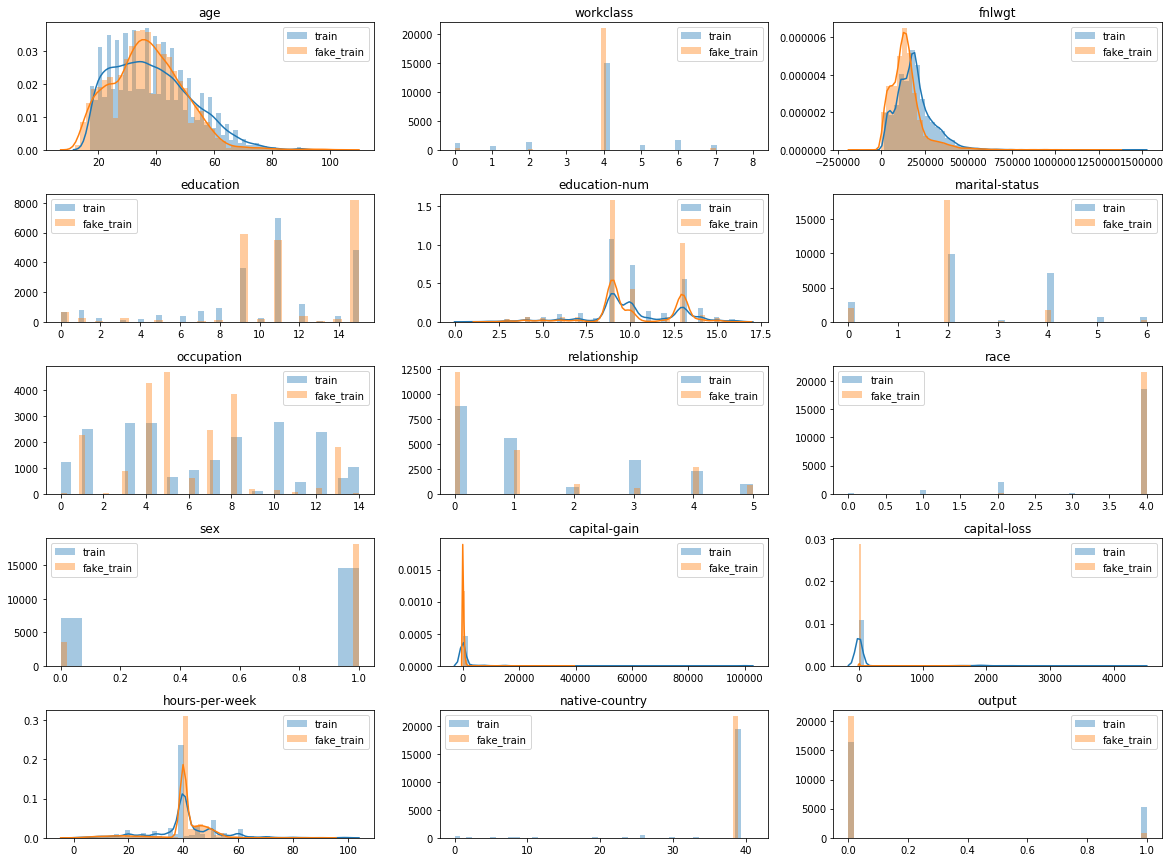

In [74]:
evaluator.plot_distributions(model_run=2, include_test=False)